In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import warnings
warnings.filterwarnings('ignore')

#CNN Model

In [ ]:
# XceptionNet
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
# import face_recognition
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F

import math

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        batch, sequences, channels, height, width = x.size()
        x = x.view(batch * sequences, channels, height, width)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(batch, sequences, -1)
        x = x.mean(dim=1)  # Global Average Pooling
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def plot_image(tensor):
    image = tensor.cpu().numpy().transpose(1, 2, 0)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    # Normalize the pixel values to [0, 255]
    image = image * np.array([0.22803, 0.22145, 0.216989]) + np.array([0.43216, 0.394666, 0.37645])
    image *= 255.0
    plt.imshow(image.astype('uint8'))  # Ensure datatype is correct for displaying
    plt.show()

class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, video_paths, labels_df, transform=None, sequence_length=20):
        self.video_paths = video_paths
        self.labels = labels_df
        self.transform = transform
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_name = self.video_paths[idx]
        video_path = os.path.join('/content/drive/My Drive/new_Face_only_data/', video_name + '.mp4')

        if not os.path.exists(video_path):
            raise FileNotFoundError(f"Video file not found: {video_path}")

        frames = []
        label_entries = self.labels[self.labels['name'] == video_name]
        if label_entries.empty:
            raise ValueError(f"No label found for video {video_name}")

        label_value = label_entries['label'].values[0]
        label = 0 if label_value == 'FAKE' else 1

        for frame in self.extract_frames(video_path):
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)
            if len(frames) == self.sequence_length:
                break

        if not frames:
            raise ValueError(f"No frames could be extracted from {video_path}. Check video format and codec.")

        stacked_frames = torch.stack(frames)
        return stacked_frames, label

    def extract_frames(self, path):
        vidObj = cv2.VideoCapture(path)
        success, image = vidObj.read()
        while success:
            yield image
            success, image = vidObj.read()

# Load and split the data
def load_and_split_data(folder_path, csv_file_path):
    # List all video files in the specified folder and remove the '.mp4' extension
    video_files = {file_name[:-4] for file_name in os.listdir(folder_path) if file_name.endswith('.mp4')}

    # Load the CSV file
    df = pd.read_csv(csv_file_path)

    # Filter the DataFrame to only include rows with filenames in your folder
    filtered_df = df[df['name'].isin(video_files)]

    # Split the video files for training, validation, and testing
    video_files = filtered_df['name'].tolist()  # Assuming you want to split based on the csv file

    # Splitting into training and temp (validation + test)
    train_videos, temp_videos = train_test_split(video_files, test_size=0.2, random_state=42)

    # Splitting temp into validation and test
    valid_videos, test_videos = train_test_split(temp_videos, test_size=0.25, random_state=42)  # 0.25 * 0.2 = 0.05

    return train_videos, valid_videos, test_videos, filtered_df

# Define transformations
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transforms = train_transforms  # Same transformations for validation

# Create datasets using the previously defined `video_dataset` class
def create_datasets(train_videos, valid_videos, test_videos, filtered_df, sequence_length=10):
    train_data = VideoDataset(train_videos, filtered_df, sequence_length=sequence_length, transform=train_transforms)
    val_data = VideoDataset(valid_videos, filtered_df, sequence_length=sequence_length, transform=val_transforms)
    test_data = VideoDataset(test_videos, filtered_df, sequence_length=sequence_length, transform=val_transforms)
    return train_data, val_data, test_data

# Create DataLoaders
def create_dataloaders(train_data, val_data, test_data, batch_size=4):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, valid_loader, test_loader


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Train the model
def train_model(model, criterion, optimizer, train_loader, valid_loader, epochs=10, device='cuda'):
    train_losses = []
    valid_losses = []
    train_accuracy = []
    valid_accuracy = []
    train_precision = []
    valid_precision = []
    train_recall = []
    valid_recall = []
    train_f1 = []
    valid_f1 = []
    train_conf_matrix = []
    valid_conf_matrix = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        true_labels = []
        predicted_labels = []
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy.append(100 * correct / total)
        train_precision.append(precision_score(true_labels, predicted_labels, average='binary'))
        train_recall.append(recall_score(true_labels, predicted_labels, average='binary'))
        train_f1.append(f1_score(true_labels, predicted_labels, average='binary'))
        train_conf_matrix.append(confusion_matrix(true_labels, predicted_labels))

        # Validation loss
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0
        true_labels = []
        predicted_labels = []
        with torch.no_grad():
            for data in valid_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())

        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)
        valid_accuracy.append(100 * correct / total)
        valid_precision.append(precision_score(true_labels, predicted_labels, average='binary'))
        valid_recall.append(recall_score(true_labels, predicted_labels, average='binary'))
        valid_f1.append(f1_score(true_labels, predicted_labels, average='binary'))
        valid_conf_matrix.append(confusion_matrix(true_labels, predicted_labels))

        print(f"Epoch {epoch+1}/{epochs} "
              f"Train loss: {train_loss:.4f} "
              f"Validation loss: {valid_loss:.4f} "
              f"Train accuracy: {train_accuracy[-1]:.2f}% "
              f"Validation accuracy: {valid_accuracy[-1]:.2f}%")

    # Plotting the train and validation loss
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plotting the train and validation accuracy
    plt.plot(train_accuracy, label='Training accuracy')
    plt.plot(valid_accuracy, label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Generate confusion matrix
    train_conf_matrix = sum(train_conf_matrix)
    valid_conf_matrix = sum(valid_conf_matrix)

    print("Train Confusion Matrix:")
    sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Train Confusion Matrix')
    plt.show()

    print("Validation Confusion Matrix:")
    sns.heatmap(valid_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Validation Confusion Matrix')
    plt.show()

    return train_losses, valid_losses, train_accuracy, valid_accuracy, train_precision, valid_precision, train_recall, valid_recall, train_f1, valid_f1

# Test the model
def test_model(model, test_loader, device='cuda'):
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(true_labels, predicted_labels, average='binary')
    recall = recall_score(true_labels, predicted_labels, average='binary')
    f1 = f1_score(true_labels, predicted_labels, average='binary')
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    print('Accuracy of the network on the test videos: %d %%' % accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", conf_matrix)

    # Plotting the confusion matrix
    print("Confusion Matrix:")
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy


Epoch 1/20 Train loss: 0.7167 Validation loss: 0.6902 Train accuracy: 51.36% Validation accuracy: 52.17%
Epoch 2/20 Train loss: 0.6970 Validation loss: 0.6899 Train accuracy: 51.09% Validation accuracy: 50.72%
Epoch 3/20 Train loss: 0.6960 Validation loss: 0.6869 Train accuracy: 50.54% Validation accuracy: 53.62%
Epoch 4/20 Train loss: 0.6869 Validation loss: 0.6559 Train accuracy: 61.14% Validation accuracy: 65.22%
Epoch 5/20 Train loss: 0.6768 Validation loss: 0.5969 Train accuracy: 58.70% Validation accuracy: 60.87%
Epoch 6/20 Train loss: 0.6422 Validation loss: 0.5536 Train accuracy: 63.32% Validation accuracy: 79.71%
Epoch 7/20 Train loss: 0.6247 Validation loss: 0.5756 Train accuracy: 65.76% Validation accuracy: 76.81%
Epoch 8/20 Train loss: 0.5751 Validation loss: 0.5584 Train accuracy: 70.11% Validation accuracy: 73.91%
Epoch 9/20 Train loss: 0.5706 Validation loss: 0.4431 Train accuracy: 73.37% Validation accuracy: 85.51%
Epoch 10/20 Train loss: 0.5289 Validation loss: 0.4528 

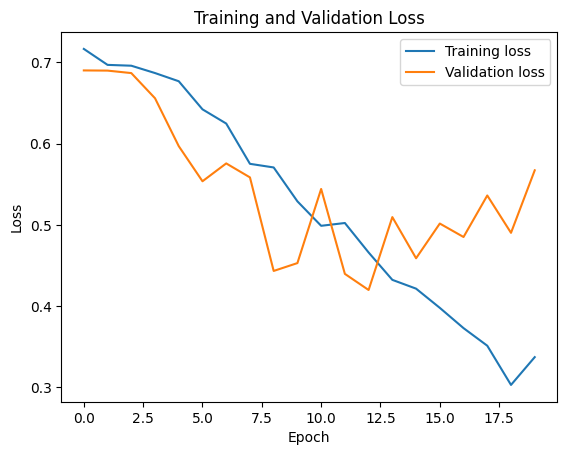

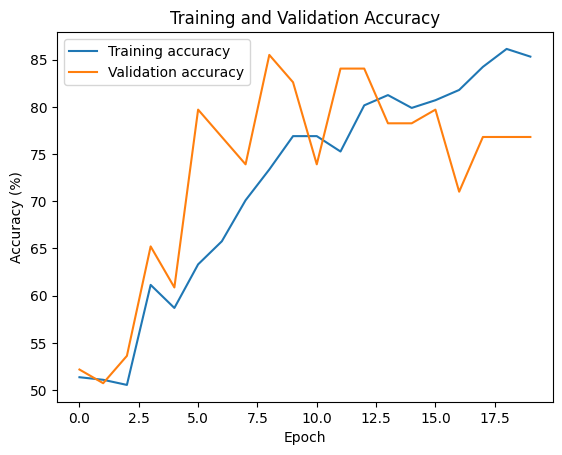

Train Confusion Matrix:


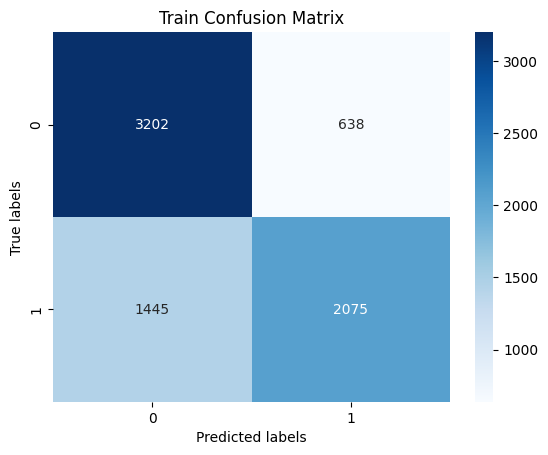

Validation Confusion Matrix:


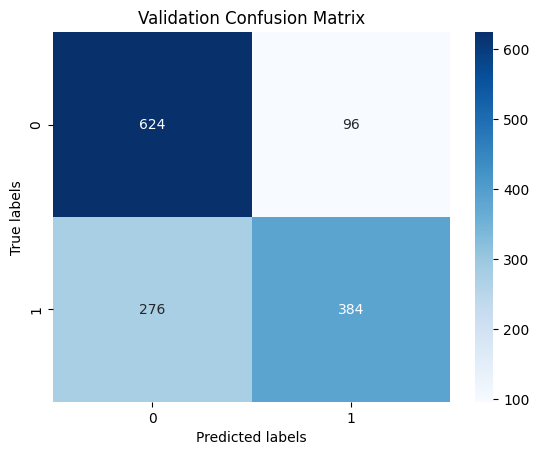

Accuracy of the network on the test videos: 69 %
Precision: 0.6875
Recall: 0.8461538461538461
F1 Score: 0.7586206896551724
Confusion Matrix:
 [[ 5  5]
 [ 2 11]]
Confusion Matrix:


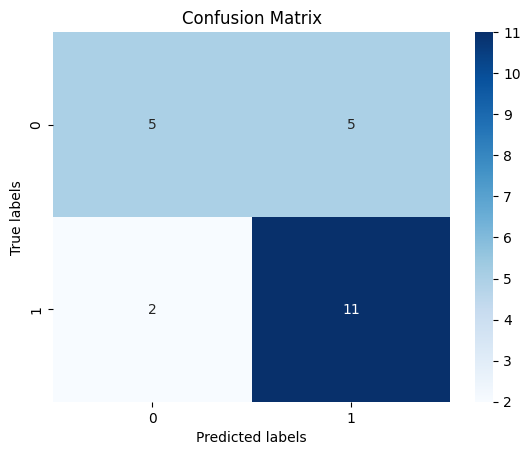

In [ ]:
# Define parameters
video_directory = '/content/drive/My Drive/new_Face_only_data/'
csv_file_path = '/content/drive/My Drive/metadata.csv'
batch_size = 4
sequence_length = 10
num_epochs = 20
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and split the data
train_videos, valid_videos, test_videos, filtered_df = load_and_split_data(video_directory, csv_file_path)

# Create datasets
train_data, val_data, test_data = create_datasets(train_videos, valid_videos, test_videos, filtered_df, sequence_length=sequence_length)

# Create DataLoaders
train_loader, valid_loader, test_loader = create_dataloaders(train_data, val_data, test_data, batch_size=batch_size)

# Initialize the model, loss function, and optimizer
model = CNNModel().to(device)
# model = Xception().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses, valid_losses, train_accuracy, valid_accuracy, train_precision, valid_precision, train_recall, valid_recall, train_f1, valid_f1 = train_model(model, criterion, optimizer, train_loader, valid_loader, epochs=num_epochs, device=device)

# Test the model
accuracy = test_model(model, test_loader, device=device)
torch.save(model.state_dict(), 'CnnModel.pth')

#Xception Net

In [ ]:
# XceptionNet
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
# import face_recognition
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F

import math

def conv_block(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, bias=True):
    return nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, bias=bias)

def separable_conv_block(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, bias=True):
    depthwise = conv_block(in_channels, in_channels, kernel_size, stride, padding, dilation, bias)
    pointwise = conv_block(in_channels, out_channels, 1, 1, 0, 1, bias)
    return nn.Sequential(depthwise, pointwise)

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, bias=True):
        super(SeparableConv2d, self).__init__()
        self.separable_conv = separable_conv_block(in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

    def forward(self, x):
        return self.separable_conv(x)

class Xception(nn.Module):
    def __init__(self, num_classes=2):
        super(Xception, self).__init__()

        self.features = nn.Sequential(
            conv_block(3, 32, 3, 2, 0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            conv_block(32, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            SeparableConv2d(64, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            SeparableConv2d(128, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(3, 2, 0),

            SeparableConv2d(128, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            SeparableConv2d(256, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(3, 2, 0),

            SeparableConv2d(256, 728, 3, 1, 1, bias=False),
            nn.BatchNorm2d(728),
            nn.ReLU(inplace=True),
            SeparableConv2d(728, 728, 3, 1, 1, bias=False),
            nn.BatchNorm2d(728),
            nn.MaxPool2d(3, 2, 0, ceil_mode=True),

            SeparableConv2d(728, 728, 3, 1, 1, bias=False),
            nn.BatchNorm2d(728),
            nn.ReLU(inplace=True),
            SeparableConv2d(728, 728, 3, 1, 1, bias=False),
            nn.BatchNorm2d(728),
            nn.MaxPool2d(3, 2, 0, ceil_mode=True),

            SeparableConv2d(728, 728, 3, 1, 1, bias=False),
            nn.BatchNorm2d(728),
            nn.ReLU(inplace=True),
            SeparableConv2d(728, 728, 3, 1, 1, bias=False),
            nn.BatchNorm2d(728),
            nn.MaxPool2d(3, 2, 0, ceil_mode=True),
        )

        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Sequential(
            nn.Linear(728, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        batch_size, seq_len, channels, height, width = x.size()
        x = x.view(batch_size * seq_len, channels, height, width)
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(batch_size, seq_len, -1)
        x = x.mean(dim=1)  # Average across the sequence dimension
        x = self.fc(x)
        return x

def plot_image(tensor):
    image = tensor.cpu().numpy().transpose(1, 2, 0)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    # Normalize the pixel values to [0, 255]
    image = image * np.array([0.22803, 0.22145, 0.216989]) + np.array([0.43216, 0.394666, 0.37645])
    image *= 255.0
    plt.imshow(image.astype('uint8'))  # Ensure datatype is correct for displaying
    plt.show()

class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, video_paths, labels_df, transform=None, sequence_length=20):
        self.video_paths = video_paths
        self.labels = labels_df
        self.transform = transform
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_name = self.video_paths[idx]
        video_path = os.path.join('/content/drive/My Drive/new_Face_only_data/', video_name + '.mp4')

        if not os.path.exists(video_path):
            raise FileNotFoundError(f"Video file not found: {video_path}")

        frames = []
        label_entries = self.labels[self.labels['name'] == video_name]
        if label_entries.empty:
            raise ValueError(f"No label found for video {video_name}")

        label_value = label_entries['label'].values[0]
        label = 0 if label_value == 'FAKE' else 1

        for frame in self.extract_frames(video_path):
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)
            if len(frames) == self.sequence_length:
                break

        if not frames:
            raise ValueError(f"No frames could be extracted from {video_path}. Check video format and codec.")

        stacked_frames = torch.stack(frames)
        return stacked_frames, label

    def extract_frames(self, path):
        vidObj = cv2.VideoCapture(path)
        success, image = vidObj.read()
        while success:
            yield image
            success, image = vidObj.read()

# Load and split the data
def load_and_split_data(folder_path, csv_file_path):
    # List all video files in the specified folder and remove the '.mp4' extension
    video_files = {file_name[:-4] for file_name in os.listdir(folder_path) if file_name.endswith('.mp4')}

    # Load the CSV file
    df = pd.read_csv(csv_file_path)

    # Filter the DataFrame to only include rows with filenames in your folder
    filtered_df = df[df['name'].isin(video_files)]

    # Split the video files for training, validation, and testing
    video_files = filtered_df['name'].tolist()  # Assuming you want to split based on the csv file

    # Splitting into training and temp (validation + test)
    train_videos, temp_videos = train_test_split(video_files, test_size=0.2, random_state=42)

    # Splitting temp into validation and test
    valid_videos, test_videos = train_test_split(temp_videos, test_size=0.25, random_state=42)  # 0.25 * 0.2 = 0.05

    return train_videos, valid_videos, test_videos, filtered_df

# Define transformations
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transforms = train_transforms  # Same transformations for validation

# Create datasets using the previously defined `video_dataset` class
def create_datasets(train_videos, valid_videos, test_videos, filtered_df, sequence_length=10):
    train_data = VideoDataset(train_videos, filtered_df, sequence_length=sequence_length, transform=train_transforms)
    val_data = VideoDataset(valid_videos, filtered_df, sequence_length=sequence_length, transform=val_transforms)
    test_data = VideoDataset(test_videos, filtered_df, sequence_length=sequence_length, transform=val_transforms)
    return train_data, val_data, test_data

# Create DataLoaders
def create_dataloaders(train_data, val_data, test_data, batch_size=4):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, valid_loader, test_loader

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Train the model
def train_model(model, criterion, optimizer, train_loader, valid_loader, epochs=10, device='cuda'):
    train_losses = []
    valid_losses = []
    train_accuracy = []
    valid_accuracy = []
    train_precision = []
    valid_precision = []
    train_recall = []
    valid_recall = []
    train_f1 = []
    valid_f1 = []
    train_conf_matrix = []
    valid_conf_matrix = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        true_labels = []
        predicted_labels = []
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy.append(100 * correct / total)
        train_precision.append(precision_score(true_labels, predicted_labels, average='binary'))
        train_recall.append(recall_score(true_labels, predicted_labels, average='binary'))
        train_f1.append(f1_score(true_labels, predicted_labels, average='binary'))
        train_conf_matrix.append(confusion_matrix(true_labels, predicted_labels))

        # Validation loss
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0
        true_labels = []
        predicted_labels = []
        with torch.no_grad():
            for data in valid_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())

        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)
        valid_accuracy.append(100 * correct / total)
        valid_precision.append(precision_score(true_labels, predicted_labels, average='binary'))
        valid_recall.append(recall_score(true_labels, predicted_labels, average='binary'))
        valid_f1.append(f1_score(true_labels, predicted_labels, average='binary'))
        valid_conf_matrix.append(confusion_matrix(true_labels, predicted_labels))

        print(f"Epoch {epoch+1}/{epochs} "
              f"Train loss: {train_loss:.4f} "
              f"Validation loss: {valid_loss:.4f} "
              f"Train accuracy: {train_accuracy[-1]:.2f}% "
              f"Validation accuracy: {valid_accuracy[-1]:.2f}%")

    # Plotting the train and validation loss
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plotting the train and validation accuracy
    plt.plot(train_accuracy, label='Training accuracy')
    plt.plot(valid_accuracy, label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Generate confusion matrix
    train_conf_matrix = sum(train_conf_matrix)
    valid_conf_matrix = sum(valid_conf_matrix)

    print("Train Confusion Matrix:")
    sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Train Confusion Matrix')
    plt.show()

    print("Validation Confusion Matrix:")
    sns.heatmap(valid_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Validation Confusion Matrix')
    plt.show()

    return train_losses, valid_losses, train_accuracy, valid_accuracy, train_precision, valid_precision, train_recall, valid_recall, train_f1, valid_f1

# Test the model
def test_model(model, test_loader, device='cuda'):
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(true_labels, predicted_labels, average='binary')
    recall = recall_score(true_labels, predicted_labels, average='binary')
    f1 = f1_score(true_labels, predicted_labels, average='binary')
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    print('Accuracy of the network on the test videos: %d %%' % accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", conf_matrix)

    # Plotting the confusion matrix
    print("Confusion Matrix:")
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy


Epoch 1/20 Train loss: 0.8680 Validation loss: 0.6672 Train accuracy: 48.91% Validation accuracy: 47.83%
Epoch 2/20 Train loss: 0.6915 Validation loss: 0.6806 Train accuracy: 50.54% Validation accuracy: 52.17%
Epoch 3/20 Train loss: 0.6917 Validation loss: 0.6926 Train accuracy: 54.08% Validation accuracy: 55.07%
Epoch 4/20 Train loss: 0.6869 Validation loss: 0.6807 Train accuracy: 57.88% Validation accuracy: 68.12%
Epoch 5/20 Train loss: 0.6743 Validation loss: 0.6389 Train accuracy: 61.41% Validation accuracy: 75.36%
Epoch 6/20 Train loss: 0.6531 Validation loss: 0.5780 Train accuracy: 64.95% Validation accuracy: 62.32%
Epoch 7/20 Train loss: 0.6119 Validation loss: 0.6124 Train accuracy: 68.21% Validation accuracy: 71.01%
Epoch 8/20 Train loss: 0.5892 Validation loss: 0.5995 Train accuracy: 69.02% Validation accuracy: 79.71%
Epoch 9/20 Train loss: 0.5496 Validation loss: 0.5061 Train accuracy: 72.01% Validation accuracy: 81.16%
Epoch 10/20 Train loss: 0.5060 Validation loss: 0.6285 

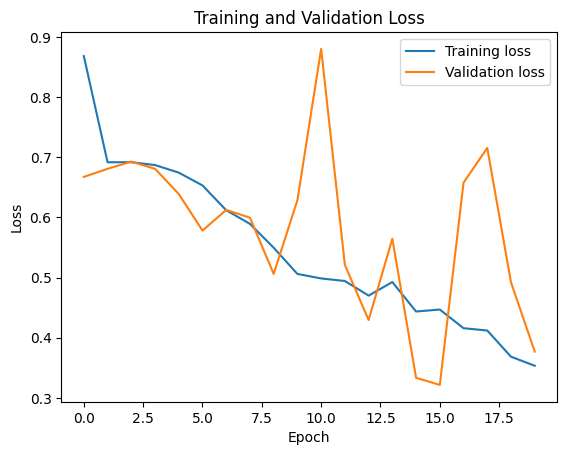

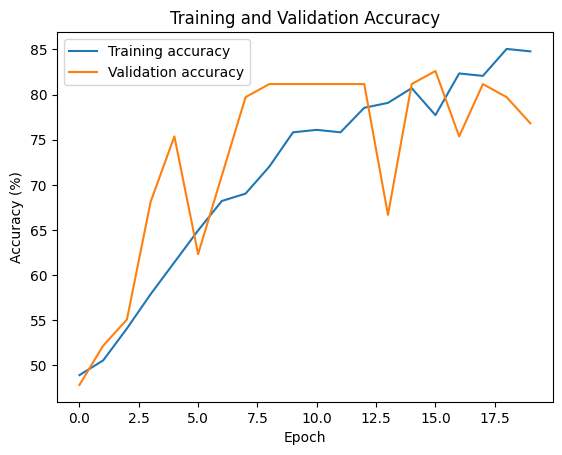

Train Confusion Matrix:


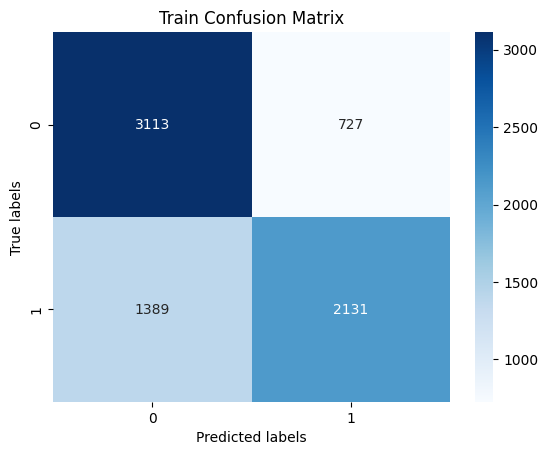

Validation Confusion Matrix:


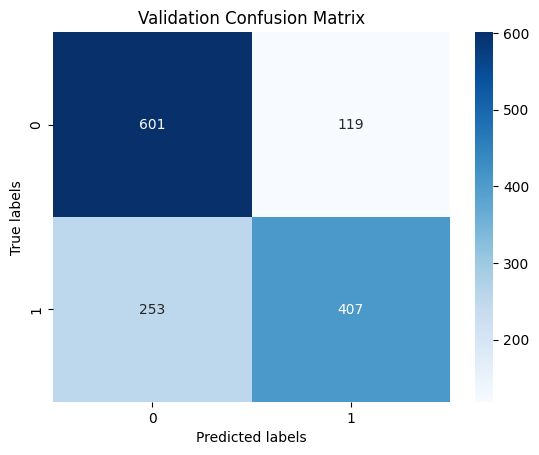

Accuracy of the network on the test videos: 65 %
Precision: 0.6470588235294118
Recall: 0.8461538461538461
F1 Score: 0.7333333333333334
Confusion Matrix:
 [[ 4  6]
 [ 2 11]]
Confusion Matrix:


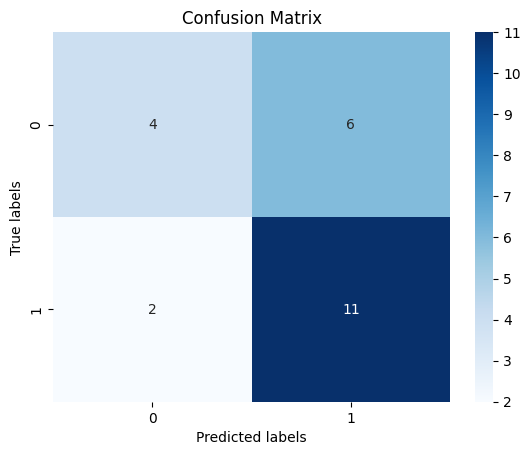

In [ ]:
# Define parameters
video_directory = '/content/drive/My Drive/new_Face_only_data/'
csv_file_path = '/content/drive/My Drive/metadata.csv'
batch_size = 64
sequence_length = 10
num_epochs = 20
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and split the data
train_videos, valid_videos, test_videos, filtered_df = load_and_split_data(video_directory, csv_file_path)

# Create datasets
train_data, val_data, test_data = create_datasets(train_videos, valid_videos, test_videos, filtered_df, sequence_length=sequence_length)

# Create DataLoaders
train_loader, valid_loader, test_loader = create_dataloaders(train_data, val_data, test_data, batch_size=batch_size)

# Initialize the model, loss function, and optimizer
# model = SimpleCNN().to(device)
model = Xception().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses, valid_losses, train_accuracy, valid_accuracy, train_precision, valid_precision, train_recall, valid_recall, train_f1, valid_f1 = train_model(model, criterion, optimizer, train_loader, valid_loader, epochs=num_epochs, device=device)

# Test the model
accuracy = test_model(model, test_loader, device=device)
torch.save(model.state_dict(), 'xception.pt')

#Efficient Net

In [6]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

In [ ]:
# XceptionNet
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
# import face_recognition
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F

import math
from efficientnet_pytorch import EfficientNet

class Efficient(nn.Module):
    def __init__(self, num_classes = 2):
        super(Efficient, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
        self.fc = nn.Linear(self.efficientnet._fc.in_features, num_classes)

    def forward(self, x):
        batch_size, seq_len, channels, height, width = x.size()
        x = x.view(batch_size * seq_len, channels, height, width)
        x = self.efficientnet.extract_features(x)
        x = self.efficientnet._avg_pooling(x)
        x = x.view(batch_size, seq_len, -1)
        x = x.mean(dim=1)  # Average across the sequence dimension
        x = self.fc(x)
        return x

def plot_image(tensor):
    image = tensor.cpu().numpy().transpose(1, 2, 0)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    # Normalize the pixel values to [0, 255]
    image = image * np.array([0.22803, 0.22145, 0.216989]) + np.array([0.43216, 0.394666, 0.37645])
    image *= 255.0
    plt.imshow(image.astype('uint8'))  # Ensure datatype is correct for displaying
    plt.show()

class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, video_paths, labels_df, transform=None, sequence_length=20):
        self.video_paths = video_paths
        self.labels = labels_df
        self.transform = transform
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_name = self.video_paths[idx]
        video_path = os.path.join('/content/drive/My Drive/new_Face_only_data/', video_name + '.mp4')

        if not os.path.exists(video_path):
            raise FileNotFoundError(f"Video file not found: {video_path}")

        frames = []
        label_entries = self.labels[self.labels['name'] == video_name]
        if label_entries.empty:
            raise ValueError(f"No label found for video {video_name}")

        label_value = label_entries['label'].values[0]
        label = 0 if label_value == 'FAKE' else 1

        for frame in self.extract_frames(video_path):
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)
            if len(frames) == self.sequence_length:
                break

        if not frames:
            raise ValueError(f"No frames could be extracted from {video_path}. Check video format and codec.")

        stacked_frames = torch.stack(frames)
        return stacked_frames, label

    def extract_frames(self, path):
        vidObj = cv2.VideoCapture(path)
        success, image = vidObj.read()
        while success:
            yield image
            success, image = vidObj.read()

# Load and split the data
def load_and_split_data(folder_path, csv_file_path):
    # List all video files in the specified folder and remove the '.mp4' extension
    video_files = {file_name[:-4] for file_name in os.listdir(folder_path) if file_name.endswith('.mp4')}

    # Load the CSV file
    df = pd.read_csv(csv_file_path)

    # Filter the DataFrame to only include rows with filenames in your folder
    filtered_df = df[df['name'].isin(video_files)]

    # Split the video files for training, validation, and testing
    video_files = filtered_df['name'].tolist()  # Assuming you want to split based on the csv file

    # Splitting into training and temp (validation + test)
    train_videos, temp_videos = train_test_split(video_files, test_size=0.2, random_state=42)

    # Splitting temp into validation and test
    valid_videos, test_videos = train_test_split(temp_videos, test_size=0.25, random_state=42)  # 0.25 * 0.2 = 0.05

    return train_videos, valid_videos, test_videos, filtered_df

# Define transformations
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transforms = train_transforms  # Same transformations for validation

# Create datasets using the previously defined `video_dataset` class
def create_datasets(train_videos, valid_videos, test_videos, filtered_df, sequence_length=10):
    train_data = VideoDataset(train_videos, filtered_df, sequence_length=sequence_length, transform=train_transforms)
    val_data = VideoDataset(valid_videos, filtered_df, sequence_length=sequence_length, transform=val_transforms)
    test_data = VideoDataset(test_videos, filtered_df, sequence_length=sequence_length, transform=val_transforms)
    return train_data, val_data, test_data

# Create DataLoaders
def create_dataloaders(train_data, val_data, test_data, batch_size=4):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, valid_loader, test_loader


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Train the model
def train_model(model, criterion, optimizer, train_loader, valid_loader, epochs=10, device='cuda'):
    train_losses = []
    valid_losses = []
    train_accuracy = []
    valid_accuracy = []
    train_precision = []
    valid_precision = []
    train_recall = []
    valid_recall = []
    train_f1 = []
    valid_f1 = []
    train_conf_matrix = []
    valid_conf_matrix = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        true_labels = []
        predicted_labels = []
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy.append(100 * correct / total)
        train_precision.append(precision_score(true_labels, predicted_labels, average='binary'))
        train_recall.append(recall_score(true_labels, predicted_labels, average='binary'))
        train_f1.append(f1_score(true_labels, predicted_labels, average='binary'))
        train_conf_matrix.append(confusion_matrix(true_labels, predicted_labels))

        # Validation loss
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0
        true_labels = []
        predicted_labels = []
        with torch.no_grad():
            for data in valid_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())

        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)
        valid_accuracy.append(100 * correct / total)
        valid_precision.append(precision_score(true_labels, predicted_labels, average='binary'))
        valid_recall.append(recall_score(true_labels, predicted_labels, average='binary'))
        valid_f1.append(f1_score(true_labels, predicted_labels, average='binary'))
        valid_conf_matrix.append(confusion_matrix(true_labels, predicted_labels))

        print(f"Epoch {epoch+1}/{epochs} "
              f"Train loss: {train_loss:.4f} "
              f"Validation loss: {valid_loss:.4f} "
              f"Train accuracy: {train_accuracy[-1]:.2f}% "
              f"Validation accuracy: {valid_accuracy[-1]:.2f}%")

    # Plotting the train and validation loss
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plotting the train and validation accuracy
    plt.plot(train_accuracy, label='Training accuracy')
    plt.plot(valid_accuracy, label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Generate confusion matrix
    train_conf_matrix = sum(train_conf_matrix)
    valid_conf_matrix = sum(valid_conf_matrix)

    print("Train Confusion Matrix:")
    sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Train Confusion Matrix')
    plt.show()

    print("Validation Confusion Matrix:")
    sns.heatmap(valid_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Validation Confusion Matrix')
    plt.show()

    return train_losses, valid_losses, train_accuracy, valid_accuracy, train_precision, valid_precision, train_recall, valid_recall, train_f1, valid_f1

# Test the model
def test_model(model, test_loader, device='cuda'):
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(true_labels, predicted_labels, average='binary')
    recall = recall_score(true_labels, predicted_labels, average='binary')
    f1 = f1_score(true_labels, predicted_labels, average='binary')
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    print('Accuracy of the network on the test videos: %d %%' % accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", conf_matrix)

    # Plotting the confusion matrix
    print("Confusion Matrix:")
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 122MB/s] 


Loaded pretrained weights for efficientnet-b0
Epoch 1/20 Train loss: 0.6548 Validation loss: 0.6420 Train accuracy: 64.13% Validation accuracy: 75.36%
Epoch 2/20 Train loss: 0.5426 Validation loss: 7.1133 Train accuracy: 73.64% Validation accuracy: 86.96%
Epoch 3/20 Train loss: 0.4851 Validation loss: 0.6464 Train accuracy: 76.90% Validation accuracy: 79.71%
Epoch 4/20 Train loss: 0.4002 Validation loss: 0.3440 Train accuracy: 84.51% Validation accuracy: 85.51%
Epoch 5/20 Train loss: 0.3834 Validation loss: 0.5417 Train accuracy: 83.70% Validation accuracy: 82.61%
Epoch 6/20 Train loss: 0.2913 Validation loss: 0.8497 Train accuracy: 87.77% Validation accuracy: 84.06%
Epoch 7/20 Train loss: 0.2670 Validation loss: 2.3401 Train accuracy: 90.49% Validation accuracy: 72.46%
Epoch 8/20 Train loss: 0.2454 Validation loss: 0.5363 Train accuracy: 90.76% Validation accuracy: 85.51%
Epoch 9/20 Train loss: 0.2085 Validation loss: 0.3812 Train accuracy: 92.12% Validation accuracy: 92.75%
Epoch 10/

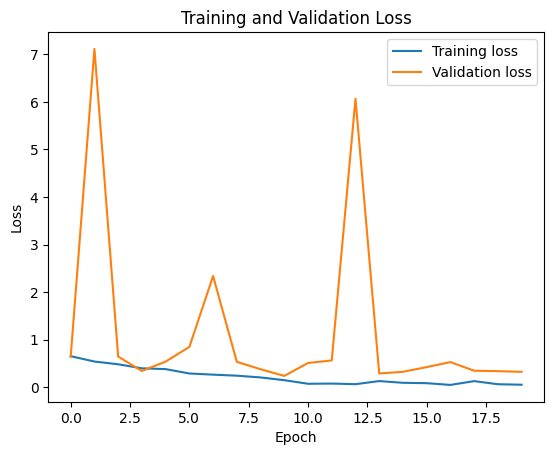

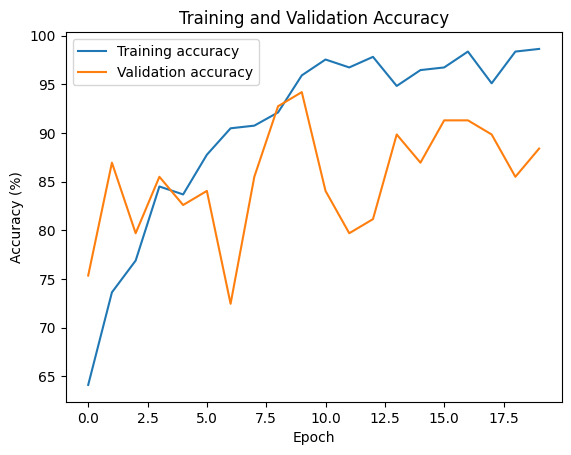

Train Confusion Matrix:


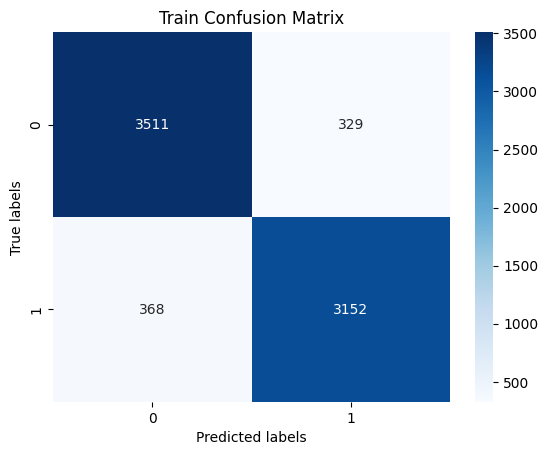

Validation Confusion Matrix:


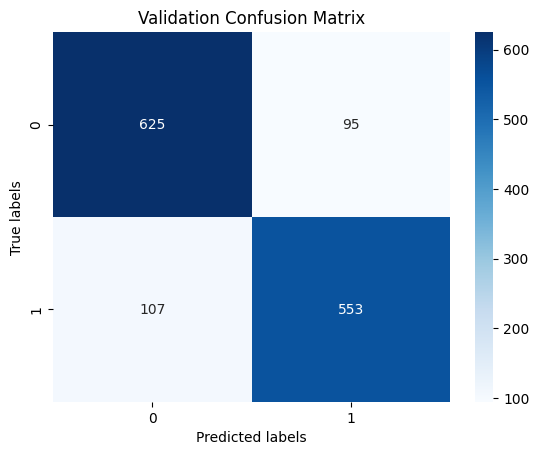

Accuracy of the network on the test videos: 86 %
Precision: 0.9166666666666666
Recall: 0.8461538461538461
F1 Score: 0.8799999999999999
Confusion Matrix:
 [[ 9  1]
 [ 2 11]]
Confusion Matrix:


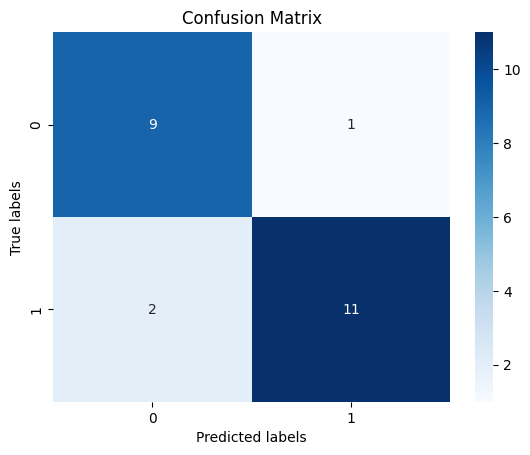

In [ ]:
# Define parameters
video_directory = '/content/drive/My Drive/new_Face_only_data/'
csv_file_path = '/content/drive/My Drive/metadata.csv'
batch_size = 4
sequence_length = 10
num_epochs = 20
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and split the data
train_videos, valid_videos, test_videos, filtered_df = load_and_split_data(video_directory, csv_file_path)

# Create datasets
train_data, val_data, test_data = create_datasets(train_videos, valid_videos, test_videos, filtered_df, sequence_length=sequence_length)

# Create DataLoaders
train_loader, valid_loader, test_loader = create_dataloaders(train_data, val_data, test_data, batch_size=batch_size)

# Initialize the model, loss function, and optimizer
model = Efficient().to(device)
# model = Xception().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses, valid_losses, train_accuracy, valid_accuracy, train_precision, valid_precision, train_recall, valid_recall, train_f1, valid_f1 = train_model(model, criterion, optimizer, train_loader, valid_loader, epochs=num_epochs, device=device)

# Test the model
accuracy = test_model(model, test_loader, device=device)
torch.save(model.state_dict(), 'Efficient.pth')

#Proposed Model

In [5]:
from torchvision import models
class EnhancedVideoModel(nn.Module):
    def __init__(self, num_classes, feature_dim=2048, num_lstm_layers=2, lstm_hidden_dim=1024, use_bidirectional=True):
        super(EnhancedVideoModel, self).__init__()
        # Using an updated version of ResNeXt with different parameters
        model_config = models.resnext101_32x8d(pretrained=True)
        self.features = nn.Sequential(*list(model_config.children())[:-2])

        # Adjust LSTM for bidirectionality and different hidden dimensions
        self.temporal_layers = nn.LSTM(input_size=feature_dim, hidden_size=lstm_hidden_dim,
                                       num_layers=num_lstm_layers, bidirectional=use_bidirectional)
        self.activation_fn = nn.ReLU()  # Changed to ReLU for stability
        self.regularization = nn.Dropout(0.5)  # Increased dropout for better generalization
        self.fc = nn.Linear(lstm_hidden_dim * 2 if use_bidirectional else lstm_hidden_dim, num_classes)
        self.global_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, inputs):
        batch, sequences, channels, height, width = inputs.size()
        inputs_reshaped = inputs.view(batch * sequences, channels, height, width)
        conv_outputs = self.features(inputs_reshaped)
        pooled_outputs = self.global_pool(conv_outputs)
        pooled_outputs = pooled_outputs.view(batch, sequences, -1)
        lstm_out, _ = self.temporal_layers(pooled_outputs)
        temporal_features = torch.mean(lstm_out, dim=1)
        activated_features = self.activation_fn(temporal_features)
        final_output = self.fc(self.regularization(activated_features))
        return conv_outputs, final_output

In [ ]:
model = EnhancedVideoModel(num_classes=2).to(device)

dummy_input = torch.zeros((1, 20, 3, 112, 112), dtype=torch.float).to(device)

# Perform a forward pass through the model
feature_maps, outputs = model(dummy_input)

In [ ]:
import torch
from torch.autograd import Variable
import time
import os
import sys

def perform_training(epoch, total_epochs, data_loader, model, loss_func, opt):
    model.train()
    loss_tracker = MetricsTracker()
    accuracy_tracker = MetricsTracker()

    for batch_idx, (data, labels) in enumerate(data_loader):
        if torch.cuda.is_available():
            labels = labels.cuda().type(torch.cuda.LongTensor)
            data = data.cuda()

        _, predictions = model(data)
        loss = loss_func(predictions, labels)
        accuracy = compute_accuracy(predictions, labels)

        loss_tracker.update(loss.item(), data.size(0))
        accuracy_tracker.update(accuracy, data.size(0))

        opt.zero_grad()
        loss.backward()
        opt.step()

        sys.stdout.write(
            f"\r[Epoch {epoch}/{total_epochs}] [Batch {batch_idx}/{len(data_loader)}] [Loss: {loss_tracker.average:.6f}, Accuracy: {accuracy_tracker.average:.2f}%]"
        )
    torch.save(model.state_dict(), os.path.join('/content', 'checkpoint_epoch_{}.pt'.format(epoch)))
    return loss_tracker.average, accuracy_tracker.average

def perform_testing(epoch, model, data_loader, loss_func):
    print('Starting Testing Phase')
    model.eval()
    loss_tracker = MetricsTracker()
    accuracy_tracker = MetricsTracker()
    predictions_list = []
    labels_list = []

    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(data_loader):
            if torch.cuda.is_available():
                labels = labels.cuda().type(torch.cuda.FloatTensor)
                data = data.cuda()

            _, predictions = model(data)
            loss = loss_func(predictions, labels.type(torch.cuda.LongTensor)).mean()
            accuracy = compute_accuracy(predictions, labels)

            labels_list.extend(labels.type(torch.cuda.LongTensor).cpu().numpy().reshape(-1).tolist())
            predictions_list.extend(torch.max(predictions, 1)[1].cpu().numpy().reshape(-1).tolist())

            loss_tracker.update(loss.item(), data.size(0))
            accuracy_tracker.update(accuracy, data.size(0))

            sys.stdout.write(
                f"\r[Batch {batch_idx}/{len(data_loader)}] [Loss: {loss_tracker.average:.6f}, Accuracy: {accuracy_tracker.average:.2f}%]"
            )
        print(f'\nFinal Testing Accuracy: {accuracy_tracker.average:.2f}%')
    return labels_list, predictions_list, loss_tracker.average, accuracy_tracker.average

class MetricsTracker:
    """Utility class to keep track of performance metrics."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.value = 0
        self.average = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.value = val
        self.sum += val * n
        self.count += n
        self.average = self.sum / self.count if self.count != 0 else 0

def compute_accuracy(outputs, targets):
    with torch.no_grad():
        _, predicted = outputs.max(1)
        correct = predicted.eq(targets).sum().item()
        accuracy = 100 * correct / targets.size(0)
    return accuracy


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Function to display confusion matrix and compute accuracy
def display_confusion_matrix(actual, predicted):
    # Calculate the confusion matrix from true and predicted labels
    conf_matrix = confusion_matrix(actual, predicted)
    print('True Positives = ', conf_matrix[0][0])
    print('False Positives = ', conf_matrix[0][1])
    print('True Negatives = ', conf_matrix[1][1])
    print('False Negatives = ', conf_matrix[1][0])
    print('\n')

    # Create a DataFrame for better visualization of the confusion matrix
    matrix_df = pd.DataFrame(conf_matrix, index=['Fake', 'Real'], columns=['Fake', 'Real'])
    sns.set(font_scale=1.4)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix_df, annot=True, annot_kws={"size": 16}, fmt='d') .
    plt.ylabel('Actual Category')
    plt.xlabel('Predicted Category')
    plt.show()

    # Calculate and print the accuracy from the confusion matrix
    total_correct = conf_matrix[0][0] + conf_matrix[1][1]
    total_elements = conf_matrix.sum()
    accuracy = (total_correct / total_elements) * 100
    print("Overall Accuracy: {:.2f}%".format(accuracy))


In [ ]:
import matplotlib.pyplot as plt

def visualize_training_loss(training_losses, validation_losses, total_epochs):
    # Preparing data for the plot
    epoch_indices = range(1, total_epochs + 1)
    print("Number of Epochs:", total_epochs)

    # Plotting training and validation loss
    plt.figure(figsize=(8, 5))
    plt.plot(epoch_indices, training_losses, 'g-', label='Training Loss')
    plt.plot(epoch_indices, validation_losses, 'b--', label='Validation Loss')
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_training_accuracy(training_accuracies, validation_accuracies, total_epochs):
    # Setting up data for the plot
    epoch_indices = range(1, total_epochs + 1)

    # Plotting training and validation accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(epoch_indices, training_accuracies, 'g-', label='Training Accuracy')
    plt.plot(epoch_indices, validation_accuracies, 'b--', label='Validation Accuracy')
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import numpy as np

# Define learning rate and number of epochs for training
learning_rate = 1e-5  # Lower learning rate
total_epochs = 20  # Define the total number of epochs for training

# Setup optimizer with weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Define the loss function with CUDA support
loss_function = nn.CrossEntropyLoss().cuda()

# Lists to track training and validation metrics
average_training_loss = []
average_training_accuracy = []
average_validation_loss = []
average_validation_accuracy = []

# Training and Validation loop
for current_epoch in range(1, total_epochs + 1):
    # Training phase
    train_loss, train_acc = perform_training(current_epoch, total_epochs, train_loader, model, loss_function, optimizer)
    average_training_loss.append(train_loss)
    average_training_accuracy.append(train_acc)

    # Testing phase
    true_labels, predicted_labels, validation_loss, validation_accuracy = perform_testing(current_epoch, model, valid_loader, loss_function)
    average_validation_loss.append(validation_loss)
    average_validation_accuracy.append(validation_accuracy)




[Epoch 1/20] [Batch 91/92] [Loss: 0.691039, Accuracy: 53.80%]Starting Testing Phase
[Batch 17/18] [Loss: 0.664837, Accuracy: 68.12%]
Final Testing Accuracy: 68.12%
[Epoch 2/20] [Batch 91/92] [Loss: 0.638086, Accuracy: 69.84%]Starting Testing Phase
[Batch 17/18] [Loss: 0.482510, Accuracy: 84.06%]
Final Testing Accuracy: 84.06%
[Epoch 3/20] [Batch 91/92] [Loss: 0.513134, Accuracy: 80.16%]Starting Testing Phase
[Batch 17/18] [Loss: 0.384405, Accuracy: 86.96%]
Final Testing Accuracy: 86.96%
[Epoch 4/20] [Batch 91/92] [Loss: 0.367521, Accuracy: 84.78%]Starting Testing Phase
[Batch 17/18] [Loss: 0.319474, Accuracy: 91.30%]
Final Testing Accuracy: 91.30%
[Epoch 5/20] [Batch 91/92] [Loss: 0.306997, Accuracy: 87.50%]Starting Testing Phase
[Batch 17/18] [Loss: 0.262072, Accuracy: 91.30%]
Final Testing Accuracy: 91.30%
[Epoch 6/20] [Batch 91/92] [Loss: 0.206827, Accuracy: 91.30%]Starting Testing Phase
[Batch 17/18] [Loss: 0.268832, Accuracy: 86.96%]
Final Testing Accuracy: 86.96%
[Epoch 7/20] [Ba

In [ ]:
torch.save(model.state_dict(), 'Proposed.pt')
# Lists to track testing metrics
average_test_loss = []
average_test_accuracy = []

# Training and Validation loop
for current_epoch in range(1):

    # Testing phase
    true_labels, predicted_labels, test_loss, validation_accuracy = perform_testing(current_epoch, model, test_loader, loss_function)
    average_test_loss.append(test_loss)
    average_test_accuracy.append(validation_accuracy)




Starting Testing Phase
[Batch 5/6] [Loss: 0.671676, Accuracy: 86.96%]
Final Testing Accuracy: 86.96%


Number of Epochs: 20


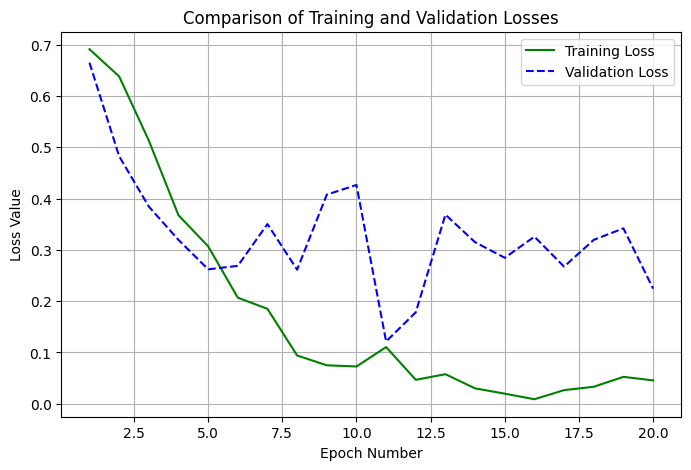

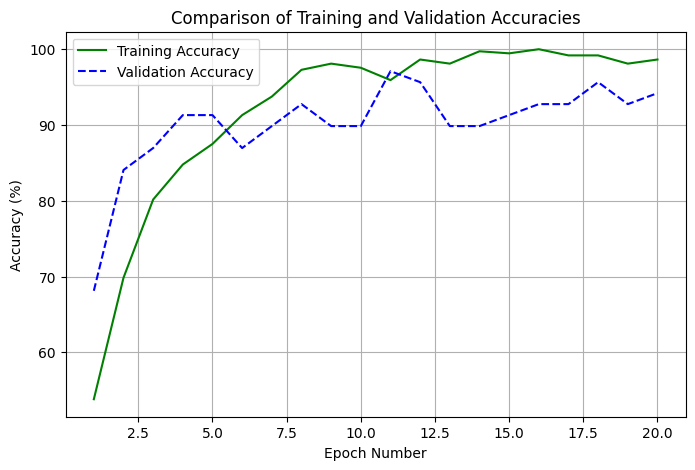

True Positives =  10
False Positives =  0
True Negatives =  10
False Negatives =  3




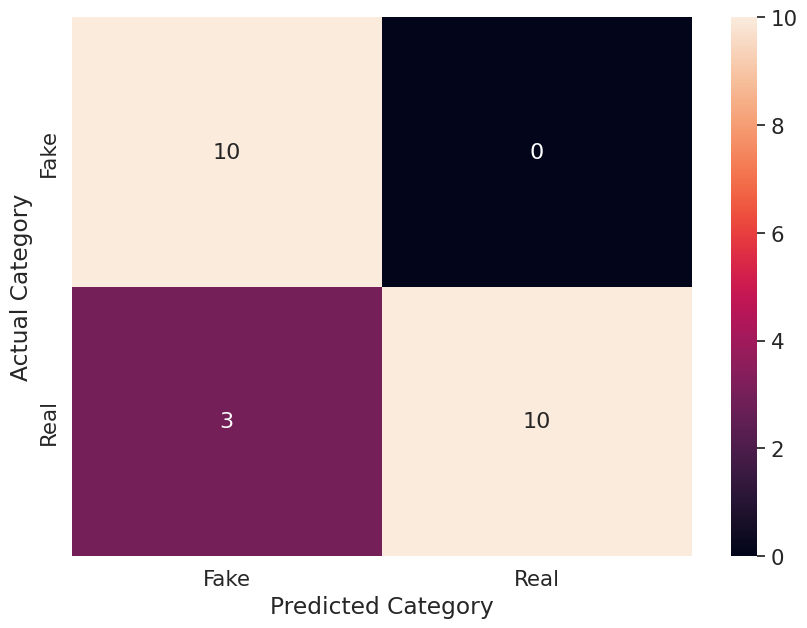

Overall Accuracy: 86.96%
None


In [ ]:
# Plot the results from training and testing
visualize_training_loss(average_training_loss, average_validation_loss, total_epochs)
visualize_training_accuracy(average_training_accuracy, average_validation_accuracy, total_epochs)

computed_confusion_matrix = display_confusion_matrix(true_labels, predicted_labels)
print(computed_confusion_matrix)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

precision = precision_score(true_labels, predicted_labels, average='binary')
print("Precision:", precision)

recall = recall_score(true_labels, predicted_labels, average='binary')
print("Recall:", recall)

f1 = f1_score(true_labels, predicted_labels, average='binary')
print("F1 Score:", f1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.8695652173913043
Precision: 1.0
Recall: 0.7692307692307693
F1 Score: 0.8695652173913044
Confusion Matrix:
 [[10  0]
 [ 3 10]]
